In [1]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
#import pickle
import os
from IPython.display import Image as displayImage
from tqdm import tqdm

In [2]:
data_path = "cifar/"

In [3]:

def load_CIFAR_batch(filename):
    try:
       with open(filename, 'rb') as f:
            datadict = pickle.load(f, encoding='bytes')
            #print (datadict[b'labels'])
            X = datadict[b'data']
            Y = datadict[b'labels']
            X = (X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float"))*-1
            Y=np.array(Y)
            return X,Y
    except EOFError:
        return {}

In [4]:

def load_data(path):
    xs = []
    ys = []
    for i in range(1,6):
        f = os.path.join(path, 'data_batch_%d' %( i, ) )
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    X_tr = np.concatenate(xs)
    Y_tr = np.concatenate(ys)
    del X, Y
    X_te , Y_te = load_CIFAR_batch(os.path.join(path, 'test_batch'))
    return X_tr, Y_tr, X_te, Y_te

In [5]:
X_tr, Y_tr, X_te, Y_te = tqdm(load_data(data_path))

100%|██████████| 4/4 [00:00<00:00, 101680.10it/s]


In [6]:
print (X_tr.shape)

(50000, 32, 32, 3)


In [7]:
def shuffleData(X_tr, Y_tr):
    perm = np.random.permutation(Y_tr.shape[0])
    X_tr = X_tr[perm,:,:,:]
    Y_tr = Y_tr[perm]
    return X_tr, Y_tr

In [27]:
X_tr, Y_tr = shuffleData(X_tr, Y_tr)

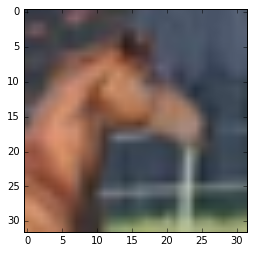

7


In [28]:
#Checking if data looks okay after randomly shuffling
plt.imshow(X_tr[9980])
plt.show()
print (Y_tr[9980])

In [29]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# img = X_tr[2518]

# # method1
# gray_image = rgb2gray(img)
# plt.imshow(gray_image, cmap = plt.get_cmap('gray'))
# plt.show()

# #method2
# gray_image = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY)
# plt.imshow(gray_image, cmap = plt.get_cmap('gray'))
# plt.show()

In [30]:
def cvt_all_data(x):
    temp = []
    for i in x:
        temp.append(rgb2gray(i))
    return (np.array(temp).astype(np.float32))

In [31]:
#Converting all training and testing data from RGB to GRAY
training_data = cvt_all_data(X_tr)
print (training_data.shape)
test_data = cvt_all_data(X_te)
# plt.imshow(training_data[9], cmap = plt.get_cmap('gray'))
# plt.show()

(50000, 32, 32)


In [32]:
#converting the labels to one hot\n"
training_labels = np.zeros((len(Y_tr),10))
testing_labels = np.zeros((len(Y_te),10))
training_labels[np.arange(len(Y_tr)), Y_tr] = 1
testing_labels[np.arange(len(Y_te)), Y_te] = 1
print (Y_tr[5:8])
print(training_labels[5:8])

[7 3 6]
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]


In [33]:
#TENSORFLOW MODEL
image_size = 32
num_labels = 10
num_channels = 3
num_imgs = 50000
batch_size = 100
patch_size = 5
num_hidden1 = 256
num_hidden2 = 128
depth = 16

In [34]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [35]:
#placeholder variables to feed data
graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, shape=[batch_size,image_size,image_size,num_channels])
    y = tf.placeholder(tf.float32, shape=[batch_size, num_labels])
    testing_data = tf.constant(X_te.astype(np.float32))
    
    l1_weights = tf.Variable(tf.truncated_normal([patch_size,patch_size,num_channels,depth], stddev=0.1))
    l1_biases = tf.Variable(tf.constant(0.1, shape=[depth]))
    
    l2_weights = tf.Variable(tf.truncated_normal([patch_size,patch_size,depth,depth], stddev=0.1))
    l2_biases = tf.Variable(tf.constant(0.1, shape=[depth]))
    
    l3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden1], stddev=0.1))
    l3_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden1]))
    
    l4_weights = tf.Variable(tf.truncated_normal([num_hidden1, num_hidden2], stddev=0.1))
    l4_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden2]))
    
    l5_weights = tf.Variable(tf.truncated_normal([num_hidden2, num_labels], stddev=0.1))
    l5_biases = tf.Variable(tf.constant(0.1, shape=[num_labels]))
    
    def model(data):
        conv = tf.nn.conv2d(data, l1_weights, [1,1,1,1], padding='SAME')
        print(conv)
        print(l1_biases)
        conv_relu = tf.nn.relu(conv + l1_biases)
        pool1 = tf.nn.max_pool(conv_relu, [1,2,2,1],[1,2,2,1], padding='SAME')
    
        conv = tf.nn.conv2d(pool1, l2_weights, [1,1,1,1], padding='SAME')
        conv_relu = tf.nn.relu(conv + l2_biases)
        pool2 = tf.nn.max_pool(conv_relu, [1,2,2,1],[1,2,2,1], padding='SAME')
        
    
        shape = pool2.get_shape().as_list()
        reshape = tf.reshape(pool2, [shape[0],shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, l3_weights) + l3_biases)
        hidden2 = tf.nn.relu(tf.matmul(hidden, l4_weights) + l4_biases)
        return tf.matmul(hidden2, l5_weights) + l5_biases
    
    logits = model(x)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = logits))
    optimizer = tf.train.GradientDescentOptimizer(0.005).minimize(loss)
    
    train_predict = tf.nn.softmax(logits)
    test_predict = tf.nn.softmax(model(testing_data))

Tensor("Conv2D:0", shape=(100, 32, 32, 16), dtype=float32)
Tensor("Variable_1/read:0", shape=(16,), dtype=float32)
Tensor("Conv2D_2:0", shape=(10000, 32, 32, 16), dtype=float32)
Tensor("Variable_1/read:0", shape=(16,), dtype=float32)


In [36]:
num_steps = 1000
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    print ("Session Started")
    for step in range(num_steps):
        offset = step*batch_size % (training_labels.shape[0] - batch_size)
        batch_data = X_tr[offset:(offset+batch_size), : , : , :]
        batch_labels = training_labels[offset:(offset+batch_size),: ]
        fdict = {x:batch_data, y:batch_labels}
        _ , l, predictions = sess.run([optimizer, loss, train_predict], feed_dict=fdict)
        if step % 50 == 0:
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_predict.eval(), testing_labels))
            

Session Started
Minibatch loss at step 0: 336.593658
Minibatch accuracy: 13.0%
Minibatch loss at step 50: 2.302455
Minibatch accuracy: 9.0%
Minibatch loss at step 100: 2.303182
Minibatch accuracy: 3.0%
Minibatch loss at step 150: 2.302014
Minibatch accuracy: 10.0%
Minibatch loss at step 200: 2.302985
Minibatch accuracy: 9.0%
Minibatch loss at step 250: 2.302403
Minibatch accuracy: 11.0%
Minibatch loss at step 300: 2.303142
Minibatch accuracy: 10.0%
Minibatch loss at step 350: 2.301762
Minibatch accuracy: 10.0%
Minibatch loss at step 400: 2.303267
Minibatch accuracy: 9.0%
Minibatch loss at step 450: 2.303127
Minibatch accuracy: 8.0%
Minibatch loss at step 500: 2.302713
Minibatch accuracy: 7.0%
Minibatch loss at step 550: 2.303152
Minibatch accuracy: 6.0%
Minibatch loss at step 600: 2.303018
Minibatch accuracy: 8.0%
Minibatch loss at step 650: 2.303205
Minibatch accuracy: 8.0%
Minibatch loss at step 700: 2.302894
Minibatch accuracy: 7.0%
Minibatch loss at step 750: 2.302590
Minibatch acc